# Adsense Analysis

Através da plataforma Google Analytics pegamos um dataset com informações sobre anuncios direcionados as buscas relacionadas as farmácias. Iremos pre-processar esse dataset, limpando outliers, removendo dados irrelevantes e tratando dados importantes ausentes e em seguida iremos apresentar estatísticas descritivas com visualizaçcões e teste de hipotestes para comparar categorias.

In [1]:
import numpy as np
import pandas as pd
import requests
import seaborn as sbn
import matplotlib.pyplot as plt
from math import log10
import warnings

pd.options.display.max_columns = None
pd.options.display.max_rows = None
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv("dataset_210316.csv", sep=";")

In [3]:
print(dataset.shape)
dataset.head()

(21306, 36)


,dateHourMinute,adMatchedQuery,city,latitude,longitude,networkDomain,networkLocation,users,flashVersion,javaEnabled,language,screenResolution,screenName,browser,operatingSystem,mobileDeviceInfo,adSlot,adMatchType,adFormat,adTargetingType,adwordsCriteriaID,impressions,adClicks,adCost,CPM,CPC,CTR,costPerConversion,sessionDuration,organicSearches,goal1Starts,pageviews,uniquePageviews,timeOnPage,exits,pageLoadTime
0,"2,01901E+11",comprar terramicina polimixina b,Carpina,"-7,845","-35,2437",planaltonet.net.br,planalto net,1,(not set),No,pt-br,640x360,farmacia12.com.br/index2.html,Chrome,Android,Asus X00LD Zenfone 4 Selfie ZD553KL,Google search: Top,Broad match,Text,Keyword,309449757504,0,0,0,0,0,0,0,0.0,0,1,1,1,0,1,0
1,"2,01901E+11",remedios homeopaticos onde comprar,Recife,"-8,0522","-34,9286",(not set),claro s.a.,1,(not set),No,pt-br,360x760,farmacia12.com.br/,Chrome,Android,(not set),Google search: Other,Phrase match,Text,Keyword,1639245696,1,1,"0,03",30,"0,03",100,"0,03",23.0,0,1,3,2,23,1,0
2,"2,01901E+11",farmácia são paulo olinda estoque,Recife,"-8,0522","-34,9286",(not set),telef nica brasil s.a,1,(not set),No,pt-br,360x640,farmacia12.com.br/,Chrome,Android,Motorola Moto G (4) Moto G4,Google search: Top,Phrase match,Text,Keyword,10334511,1,1,"0,27",270,"0,27",100,0,0.0,0,0,1,1,0,1,0
3,"2,01901E+11",farmacia independente olinda,Olinda,"-7,9906","-34,8417",(not set),claro s.a.,1,(not set),No,pt-br,360x640,farmacia12.com.br/,Chrome,Android,Samsung SM-A520F Galaxy A5 (2017),Google search: Top,Broad match,Text,Keyword,384100548605,1,1,"0,27",270,"0,27",100,"0,27",15.0,0,1,3,2,15,1,0
4,"2,01901E+11",qual o remédio certo correto para tirar dor no...,Igarassu,"-7,8333","-34,9128",naveganet.com.br,naveganet comercio e servi os ltda,1,(not set),No,pt-br,360x720,farmacia12.com.br/,Chrome,Android,(not set),Google search: Top,Phrase match,Text,Keyword,12772586,1,1,"0,27",270,"0,27",100,"0,27",11.0,0,1,2,2,11,1,0


Boa parte dos tipos estão como object, então iremos ajustar-los para tipos mais adequados como: string, category, float, int

In [4]:
dataset.dateHourMinute = pd.to_datetime(
    dataset.dateHourMinute.astype('str').str.replace(',', '').str.slice(stop=6).str.replace('E', '0'), 
    format="%Y%m"
)
dataset.adMatchedQuery = dataset.adMatchedQuery.astype('str')
dataset.city = dataset.city.astype('category')
dataset.latitude = dataset.latitude.astype('str').str.replace(',', '.').astype('float64')
dataset.longitude = dataset.longitude.astype('str').str.replace(',', '.').astype('float64')
dataset.networkDomain = dataset.networkDomain.astype('category')
dataset.networkLocation = dataset.networkLocation.astype('category')
dataset.flashVersion = dataset.flashVersion.astype('category')
dataset.javaEnabled = dataset.javaEnabled.replace({True: 'Yes', False: 'No'}).astype('bool')
dataset.language = dataset.language.astype('category')
dataset.screenResolution = dataset.screenResolution.astype('category')
dataset.screenName = dataset.screenName.astype('category')
dataset.browser = dataset.browser.astype('category')
dataset.operatingSystem = dataset.operatingSystem.astype('category')
dataset.mobileDeviceInfo = dataset.mobileDeviceInfo.astype('category')
dataset.adSlot = dataset.adSlot.astype('category')
dataset.adMatchType = dataset.adMatchType.astype('category')
dataset.adFormat = dataset.adFormat.astype('category')
dataset.adTargetingType = dataset.adTargetingType.astype('category')
dataset.adwordsCriteriaID = dataset.adwordsCriteriaID.astype('category')
dataset.impressions = dataset.impressions.astype('int64')
dataset.adClicks = dataset.adClicks.astype('int64')
dataset.adCost = dataset.adCost.astype('str').str.replace(',', '.').astype('float64')
dataset.CPM = dataset.CPM.astype('str').str.replace(',', '.').astype('float64')
dataset.CPC = dataset.CPC.astype('str').str.replace(',', '.').astype('float64')
dataset.CTR = dataset.CTR.astype('str').str.replace(',', '.').astype('float64')
dataset.costPerConversion = dataset.costPerConversion.astype('str').str.replace(',', '.').astype('float64')
dataset.sessionDuration = dataset.sessionDuration.astype('int64')

Vamos usar `.describe` para analisar todos o dados categoricos e ver o que tem valor ou não para o nosso dataset

In [5]:
dataset.describe(include=['category'])

,city,networkDomain,networkLocation,flashVersion,language,screenResolution,screenName,browser,operatingSystem,mobileDeviceInfo,adSlot,adMatchType,adFormat,adTargetingType,adwordsCriteriaID
count,21306,21306,21306,21306,21306,21306,21306,21306,21306,21306,21306,21306,21306,21306,21306
unique,72,90,279,6,31,213,13,13,6,702,5,4,2,2,277
top,Olinda,(not set),(not set),(not set),pt-br,360x640,farmacia12.com.br/,Chrome,Android,Apple iPhone,Google search: Top,Broad match,Text,Keyword,10334511
freq,8271,10839,6581,21299,20777,10198,20113,18725,19885,1342,17154,14380,21287,21287,1696


A coluna city tem 72 valores distintos, isso significa que tem mais cidades do que queremos trabalhar, pois só queremos as cidades da região metropolitana do recife, então vamos filtra-las

In [6]:
allowed_cities = [
    'Abreu e Lima', 
    'Cabo de Santo Agostinho', 
    'Camaragibe', 
    'Goiana', 
    'Igarassu', 
    'Itamaraca', 
    'Ipojuca', 
    'Itapissuma',
    'Jaboatao dos Guararapes',
    'Moreno',
    'Olinda',
    'Paulista',
    'Recife',
    'Sao Lourenco da Mata'
]

dataset = dataset[dataset.city.isin(allowed_cities)]

In [7]:
dataset.describe(include=['category'])

,city,networkDomain,networkLocation,flashVersion,language,screenResolution,screenName,browser,operatingSystem,mobileDeviceInfo,adSlot,adMatchType,adFormat,adTargetingType,adwordsCriteriaID
count,18792,18792,18792,18792,18792,18792,18792,18792,18792,18792,18792,18792,18792,18792,18792
unique,14,64,238,6,28,201,12,13,6,667,5,4,2,2,267
top,Olinda,(not set),(not set),(not set),pt-br,360x640,farmacia12.com.br/,Chrome,Android,Apple iPhone,Google search: Top,Broad match,Text,Keyword,10334511
freq,8271,9251,6248,18785,18318,8927,17758,16545,17561,1158,14961,12644,18775,18775,1514


Temos muitos `(not set)` que são os null nas colunas `networkDomain`, `networkLocation` e `flashVersion`, e essas colunas não agregam muito ao nosso dataset, então iremos apaga-las. Temos 28 valores diferente para `language` e isso não parece fazer muito sentido, pois filtramos só por cidades da RMR, e como ela não agrega muito valor ao nosso dataset, iremos apagar-la.

Outra coluna que podemos apagar é adwordsCriteriaID, pois são id unicos gerados pelo google e para esse projeto não iremos usar-los

In [8]:
dataset = dataset.drop(columns=['networkDomain', 'networkLocation', 'flashVersion', 'language', 'adwordsCriteriaID'])

In [9]:
dataset.describe(include=['category'])

,city,screenResolution,screenName,browser,operatingSystem,mobileDeviceInfo,adSlot,adMatchType,adFormat,adTargetingType
count,18792,18792,18792,18792,18792,18792,18792,18792,18792,18792
unique,14,201,12,13,6,667,5,4,2,2
top,Olinda,360x640,farmacia12.com.br/,Chrome,Android,Apple iPhone,Google search: Top,Broad match,Text,Keyword
freq,8271,8927,17758,16545,17561,1158,14961,12644,18775,18775


Algumas colunas tem poucos valores únicos, e iremos analisar-las usando `.value_counts()` para entender o que esse valores significam.

In [10]:
print(dataset.screenName.value_counts())
print()
print(dataset.browser.value_counts())
print()
print(dataset.operatingSystem.value_counts())
print()
print(dataset.adSlot.value_counts())
print()
print(dataset.adMatchType.value_counts())
print()
print(dataset.adFormat.value_counts())
print()
print(dataset.adTargetingType.value_counts())
print()

farmacia12.com.br/                                                                                                                                                                                                                                                 17758
farmacia12.com.br/index2.html                                                                                                                                                                                                                                        832
farmacia12.com.br/pagar.html                                                                                                                                                                                                                                          98
farmacia12.com.br/lista_medicamento.html                                                                                                                                                                     

A partir da célula acima conseguimos observamar que algumas colunas, `screenName`, `adFormat` e `adTargetingType` tem valores unários, então podemos remover-las.

ScreenName tem valores unários pois todos esses dados são de uma única farmácia, então todos os anuncios são direcionados para o site dela. `adForma` e `adTargetingType` são uninário pois todos os anuncios são para o buscador do google e lá só se mostra o texto.

In [11]:
dataset = dataset.drop(columns=['screenName', 'adFormat', 'adTargetingType'])

In [12]:
dataset.describe(include=['boolean'])

,javaEnabled
count,18792
unique,1
top,True
freq,18792


Vamos olhar agora para os dados numéricos do nosso dataset e ver o que é relevante ou não, e tentar identificar erros nos nosso dados.

In [13]:
dataset.describe(include=['number'], percentiles=[.25, .5, .75, .9, .99])

,latitude,longitude,users,impressions,adClicks,adCost,CPM,CPC,CTR,costPerConversion,sessionDuration,organicSearches,goal1Starts,pageviews,uniquePageviews,timeOnPage,exits,pageLoadTime
count,18792.00000,18792.000000,18792.000000,18792.000000,18792.000000,18792.000000,1.879200e+04,18792.000000,1.879200e+04,18792.000000,18792.000000,18792.000000,18792.000000,18792.000000,18792.000000,18792.000000,18792.000000,18792.000000
mean,-8.00488,-34.881276,1.001117,1.150649,1.003140,1.611762,3.951189e+14,0.211555,2.117012e+14,0.864692,71.284217,0.000958,0.706950,3.097435,2.014527,71.255428,0.994785,124.123138
std,0.04519,0.040569,0.033411,1.266024,0.492443,127.672850,3.594422e+15,0.118098,2.071043e+15,88.354133,187.347568,0.032610,0.468312,2.416688,1.001490,181.734060,0.187339,1701.595126
min,-8.39810,-35.104500,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.05220,-34.928600,1.000000,1.000000,1.000000,0.140000,1.200000e+02,0.130000,1.000000e+02,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,-7.99060,-34.873500,1.000000,1.000000,1.000000,0.260000,2.500000e+02,0.240000,1.000000e+02,0.144200,14.000000,0.000000,1.000000,3.000000,2.000000,14.000000,1.000000,0.000000
75%,-7.99060,-34.841700,1.000000,1.000000,1.000000,0.310000,3.100000e+02,0.300000,1.000000e+02,0.280000,58.000000,0.000000,1.000000,4.000000,2.000000,59.000000,1.000000,0.000000
90%,-7.93760,-34.841700,1.000000,2.000000,2.000000,0.380000,3.800000e+02,0.340000,2.000000e+02,0.340000,171.000000,0.000000,1.000000,6.000000,3.000000,173.000000,1.000000,0.000000
99%,-7.93760,-34.841700,1.000000,7.000000,2.000000,0.700000,1.309998e+16,0.440000,6.666670e+15,0.680000,1030.090000,0.000000,1.000000,12.000000,5.000000,989.270000,2.000000,0.000000
max,-7.56300,-34.841700,2.000000,21.000000,5.000000,12635.000000,5.783330e+16,1.030000,7.692310e+16,12058.000000,2937.000000,2.000000,3.000000,49.000000,10.000000,2937.000000,3.000000,76721.000000


`users`, como nós já esperávamos - como temos lat, lng, deviceInfo esperavamos que cada linha represetava um único usuário - é unário(1 até o p99), então decidimos em remover-la.

`CPM` e `CPC` são duas métricas de monetizacão de anúncios que decidirmos por não utilizar nesse projeto.

`CTR` é uma métrica super importante que parece está errada no nosso dataset, então iremos remover essa coluna e recalcular-la usando adClick/impressions

`organicSearches` é praticamente unário(0 até o p99), então nós decidimos em remover-la.

`goal1Starts` é praticamente unário(0 até o p99), então nós decidimos em remover-la.

`uniquePageviews` é uma coluna que não compreendemos bem, então optamos por remover-la

`exits` tem uma distribuição muito parecida com `adClicks`, então optamos por remover-la e a nossa taxa de rejeição sera baseado pelo tempo na página.

`pageLoadTime` foi uma decepção para o projeto, pois estavamos esperançoso para relacionar a taxa de rejeição com o tempo para carregar a pagina, mas temos menos de 1% de instancias com valores diferentes de 0. Vamos remover-la também


In [14]:
dataset = dataset.drop(columns=['users', 'CPM', 'CPC', 'CTR', 'organicSearches', 'goal1Starts', 'uniquePageviews', 'exits', 'pageLoadTime'])

In [15]:
dataset['ctr'] = dataset.adClicks.divide(dataset.impressions, fill_value=0) # quando não temos impressões o CTR é 0

In [16]:
dataset.describe(include='all', datetime_is_numeric=True)

,dateHourMinute,adMatchedQuery,city,latitude,longitude,javaEnabled,screenResolution,browser,operatingSystem,mobileDeviceInfo,adSlot,adMatchType,impressions,adClicks,adCost,costPerConversion,sessionDuration,pageviews,timeOnPage,ctr
count,18792,18792,18792,18792.00000,18792.000000,18792,18792,18792,18792,18792,18792,18792,18792.000000,18792.000000,18792.000000,18792.000000,18792.000000,18792.000000,18792.000000,16745.000000
unique,NaN,11952,14,NaN,NaN,1,201,13,6,667,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,farmacia pague menos,Olinda,NaN,NaN,True,360x640,Chrome,Android,Apple iPhone,Google search: Top,Broad match,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,344,8271,NaN,NaN,18792,8927,16545,17561,1158,14961,12644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2019-10-10 14:01:59.540160256,NaN,NaN,-8.00488,-34.881276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.150649,1.003140,1.611762,0.864692,71.284217,3.097435,71.255428,1.025961
min,2019-01-01 00:00:00,NaN,NaN,-8.39810,-35.104500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2019-04-01 00:00:00,NaN,NaN,-8.05220,-34.928600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.140000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,2019-08-01 00:00:00,NaN,NaN,-7.99060,-34.873500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.260000,0.144200,14.000000,3.000000,14.000000,1.000000
75%,2020-04-01 00:00:00,NaN,NaN,-7.99060,-34.841700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.310000,0.280000,58.000000,4.000000,59.000000,1.000000
max,2021-03-01 00:00:00,NaN,NaN,-7.56300,-34.841700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.000000,5.000000,12635.000000,12058.000000,2937.000000,49.000000,2937.000000,3.000000


Uma coluna que quase passou despercebida foi `javaEnabled`, ela está completamente setada como true, então iremos remover-la.

In [17]:
dataset = dataset.drop(columns=['javaEnabled'])

Iremos remover todos os `(not set)` de colunas categoricas ou object

In [18]:
print(dataset.shape)
for column in dataset.columns:
    if dataset.dtypes[column].name == 'category' or dataset.dtypes[column].name == 'object':
        dataset = dataset[(dataset[column] != '(not set)')]
        if dataset.dtypes[column].name == 'category':
            dataset[column].cat.remove_unused_categories()
print(dataset.shape)
dataset.reset_index(drop=True, inplace=True)

(18792, 19)
(18158, 19)


Agora vamos discretizar o `screenResolution` em 4 bins: small, medium, large, xlarge

In [19]:
def transformScreenResolutionInDPI(resolution):
    x = resolution.split('x')
    if len(x) > 1:
        return int(x[0]) * int(x[1])
    return 0
    
dataset['screenResolutionDist'] = pd.cut(dataset.screenResolution.apply(transformScreenResolutionInDPI), 4, labels=['small', 'medium', 'large', 'xlarge'])

Com a lat/lng iremos usar um geocoding reverso para trazer a granularidade de bairro(locality) para o dataset

In [20]:
cache = dict()

def getLocality(*args):
    if args in cache:
        return cache[args]
    request = requests.get(f'https://api.bigdatacloud.net/data/reverse-geocode-client?latitude={args[0]}&longitude={args[1]}&localityLanguage=pt')
    result = request.json()['locality']
    cache[args] = result
    return result

dataset['locality'] = dataset.apply(lambda x: getLocality(x.latitude, x.longitude), axis=1)

In [21]:
dataset = dataset.drop(columns=['latitude', 'longitude'])

In [22]:
dataset.head()

,dateHourMinute,adMatchedQuery,city,screenResolution,browser,operatingSystem,mobileDeviceInfo,adSlot,adMatchType,impressions,adClicks,adCost,costPerConversion,sessionDuration,pageviews,timeOnPage,ctr,screenResolutionDist,locality
0,2019-01-01,farmácia são paulo olinda estoque,Recife,360x640,Chrome,Android,Motorola Moto G (4) Moto G4,Google search: Top,Phrase match,1,1,0.27,0.00,0,1,0,1.0,small,Cordeiro
1,2019-01-01,farmacia independente olinda,Olinda,360x640,Chrome,Android,Samsung SM-A520F Galaxy A5 (2017),Google search: Top,Broad match,1,1,0.27,0.27,15,3,15,1.0,small,Casa Caiada
2,2019-01-01,vick baby rub comprar,Olinda,360x640,Chrome,Android,Samsung SM-G531H Galaxy Grand Prime,Google search: Other,Broad match,1,1,0.23,0.23,276,13,276,1.0,small,Casa Caiada
3,2019-01-01,lacday similar,Recife,320x569,Chrome,Android,Samsung SM-G570M J5 Prime,Google search: Top,Phrase match,1,1,0.27,0.27,38,3,38,1.0,small,Cordeiro
4,2019-01-01,hemitartarato de rivastigmina de 3 grama,Olinda,360x640,Chrome,Android,Samsung SM-G531BT Galaxy Grand Prime,Google search: Top,Broad match,0,0,0.00,0.00,10,2,10,NaN,small,Casa Caiada


In [23]:
print(dataset.locality.value_counts())
print(dataset.city.value_counts())

Casa Caiada                  8052
Cordeiro                     6809
Paulista                     3077
Abreu e Lima                   49
Igarassu                       44
São Lourenço da Mata           36
Piedade                        35
Camaragibe                     18
Centro                         16
Ipojuca                         7
Cidade Criança Área Rural       6
Moreno                          4
Goiana                          4
Ilha de Itamaracá               1
Name: locality, dtype: int64
Olinda                      8052
Recife                      6809
Paulista                    3077
Abreu e Lima                  49
Igarassu                      44
Sao Lourenco da Mata          36
Jaboatao dos Guararapes       35
Camaragibe                    18
Cabo de Santo Agostinho       16
Ipojuca                        7
Itapissuma                     6
Goiana                         4
Moreno                         4
Itamaraca                      1
Gravata                        0


Como podemos ver na célula acima, todas a lat/lng são unicas por cidade. Tentamos entender o que ouve, mas ja chegou assim do analytics para gente. Acreditamos que seja algum mecanismo para preservar a privacidade do usuário.

Removendo duplicados do dataset

In [24]:
print(dataset.shape)
dataset.drop_duplicates(inplace=True)
print(dataset.shape)

(18158, 19)
(17987, 19)


In [25]:
dataset.ctr = dataset.ctr.fillna(0)

In [26]:
dataset.head()

,dateHourMinute,adMatchedQuery,city,screenResolution,browser,operatingSystem,mobileDeviceInfo,adSlot,adMatchType,impressions,adClicks,adCost,costPerConversion,sessionDuration,pageviews,timeOnPage,ctr,screenResolutionDist,locality
0,2019-01-01,farmácia são paulo olinda estoque,Recife,360x640,Chrome,Android,Motorola Moto G (4) Moto G4,Google search: Top,Phrase match,1,1,0.27,0.00,0,1,0,1.0,small,Cordeiro
1,2019-01-01,farmacia independente olinda,Olinda,360x640,Chrome,Android,Samsung SM-A520F Galaxy A5 (2017),Google search: Top,Broad match,1,1,0.27,0.27,15,3,15,1.0,small,Casa Caiada
2,2019-01-01,vick baby rub comprar,Olinda,360x640,Chrome,Android,Samsung SM-G531H Galaxy Grand Prime,Google search: Other,Broad match,1,1,0.23,0.23,276,13,276,1.0,small,Casa Caiada
3,2019-01-01,lacday similar,Recife,320x569,Chrome,Android,Samsung SM-G570M J5 Prime,Google search: Top,Phrase match,1,1,0.27,0.27,38,3,38,1.0,small,Cordeiro
4,2019-01-01,hemitartarato de rivastigmina de 3 grama,Olinda,360x640,Chrome,Android,Samsung SM-G531BT Galaxy Grand Prime,Google search: Top,Broad match,0,0,0.00,0.00,10,2,10,0.0,small,Casa Caiada


### Numero de cliques

<AxesSubplot:xlabel='adClicks', ylabel='Count'>

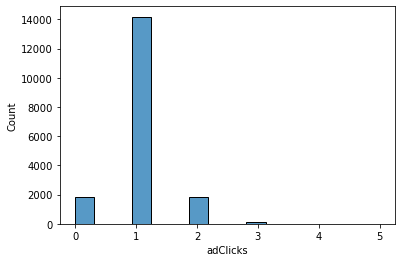

In [27]:
sbn.histplot(dataset.adClicks)

### Distribuição preço dos anuncios

<AxesSubplot:xlabel='adCost', ylabel='Density'>

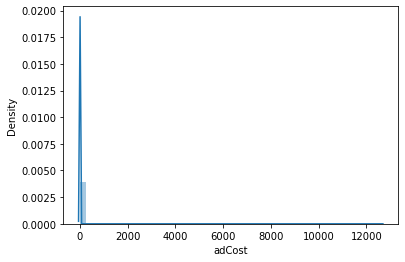

In [28]:
sbn.distplot(dataset.adCost)

<AxesSubplot:xlabel='adCost', ylabel='Density'>

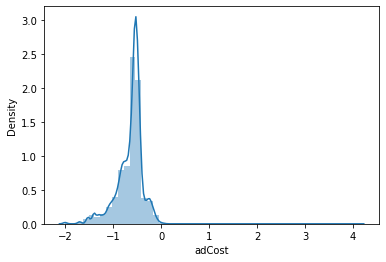

In [37]:
x = dataset[dataset.adCost > 0].adCost
sbn.distplot(x.apply(log10))

### Preço médio de anúncio por cidade

<AxesSubplot:ylabel='city'>

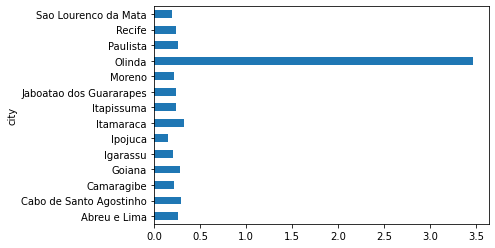

In [43]:
dataset.groupby(by='city').mean().adCost.dropna().plot.barh()

### Preço do anúncio por tempo na página

<AxesSubplot:xlabel='adCost', ylabel='timeOnPage'>

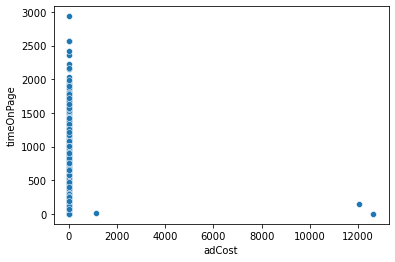

In [45]:
sbn.scatterplot(x=dataset.adCost, y=dataset.timeOnPage)

<AxesSubplot:xlabel='adCost', ylabel='timeOnPage'>

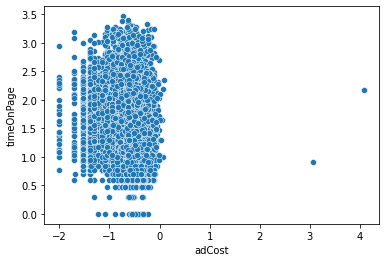

In [52]:
x = dataset[dataset.adCost > 0].adCost
y = dataset[dataset.timeOnPage > 0].timeOnPage
sbn.scatterplot(x=x.apply(log10), y=y.apply(log10))

Não existe correlação entre o tempo na página e o preço do anuncio

### Distribuição tempo na página

<AxesSubplot:xlabel='timeOnPage', ylabel='Density'>

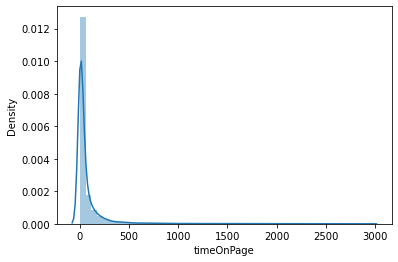

In [49]:
sbn.distplot(dataset.timeOnPage)

<AxesSubplot:ylabel='Density'>

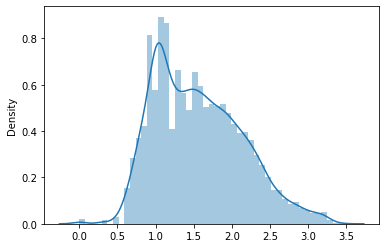

In [53]:
x = dataset[dataset.timeOnPage > 0].timeOnPage
sbn.distplot(x=x.apply(log10))

### Tempo na página por resolução de tela

<AxesSubplot:ylabel='screenResolutionDist'>

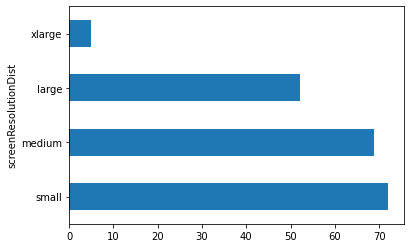

In [54]:
dataset.groupby(by='screenResolutionDist').mean().timeOnPage.dropna().plot.barh()

### Preço de anuncio por sistema operacional

<AxesSubplot:ylabel='operatingSystem'>

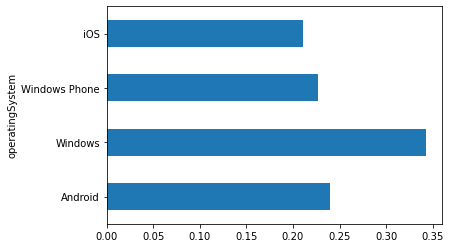

In [60]:
dataset[dataset.adCost < 1].groupby(by='operatingSystem').mean().adCost.dropna().plot.barh() # REMOVER OUTLIER

### Page view por tempo médio na pagina

<AxesSubplot:ylabel='pageviews'>

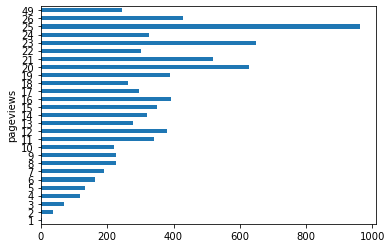

In [68]:
dataset.groupby(by='pageviews').mean().timeOnPage.dropna().plot.barh()